In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 8
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, -1, 0]
ng_refs = [3, 2, 3]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 1900
vmin = 1380
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66), (1.66, 1.66, 1.66)]
wgt = [(0.55, 0.55, 0.85), (0.85, 0.85), (0, 0.3, 0.55)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

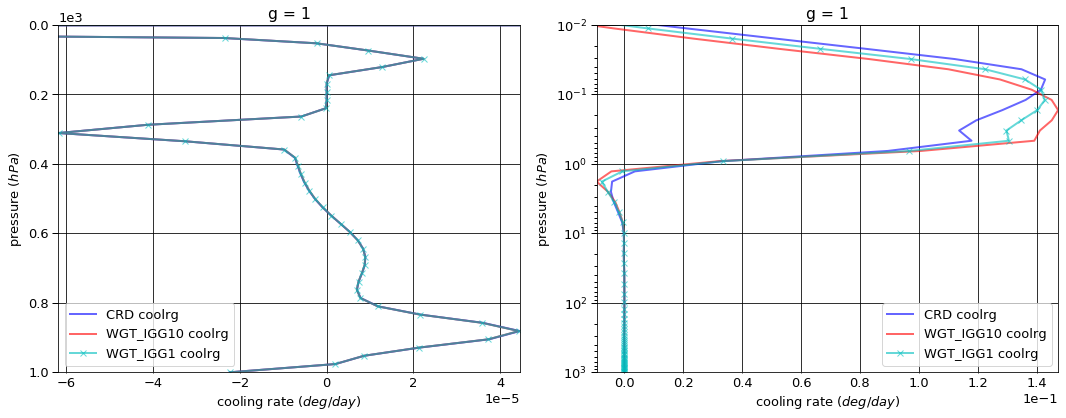

# Figure: cooling rate g-group 2

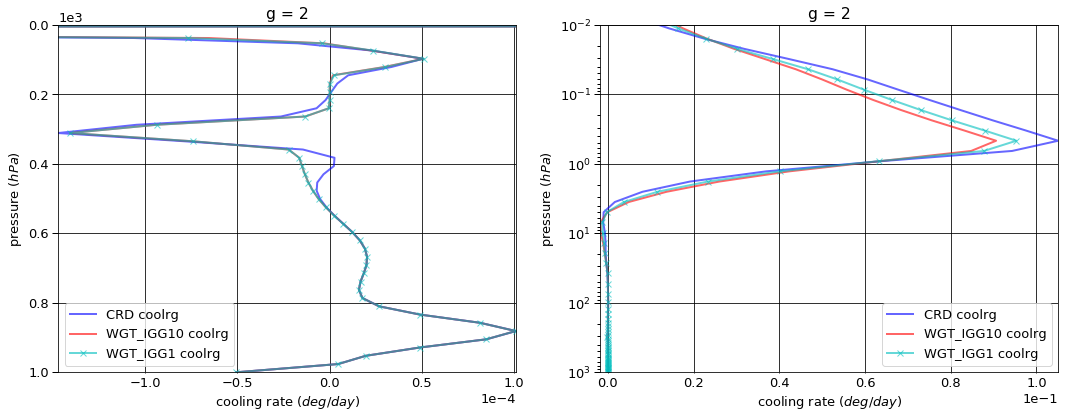

# Figure: cooling rate g-group 3

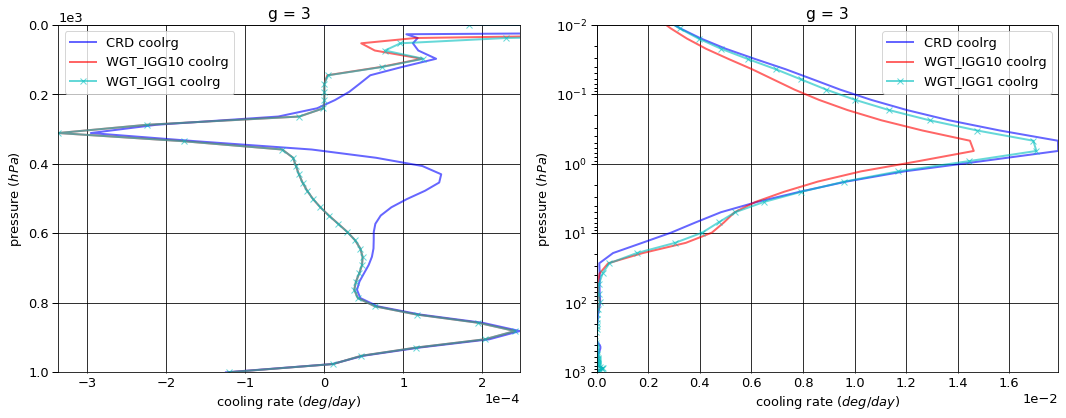

# Figure: cooling rate g-group 4

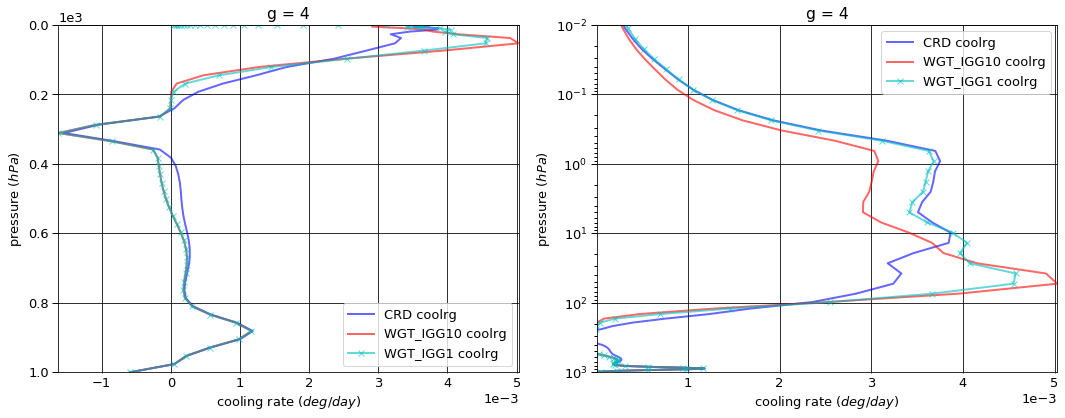

# Figure: cooling rate g-group 5

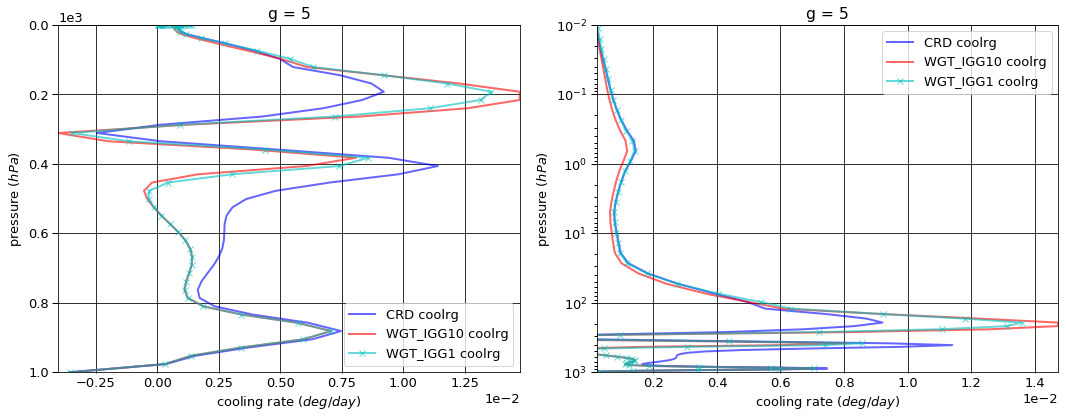

# Figure: cooling rate g-group 6

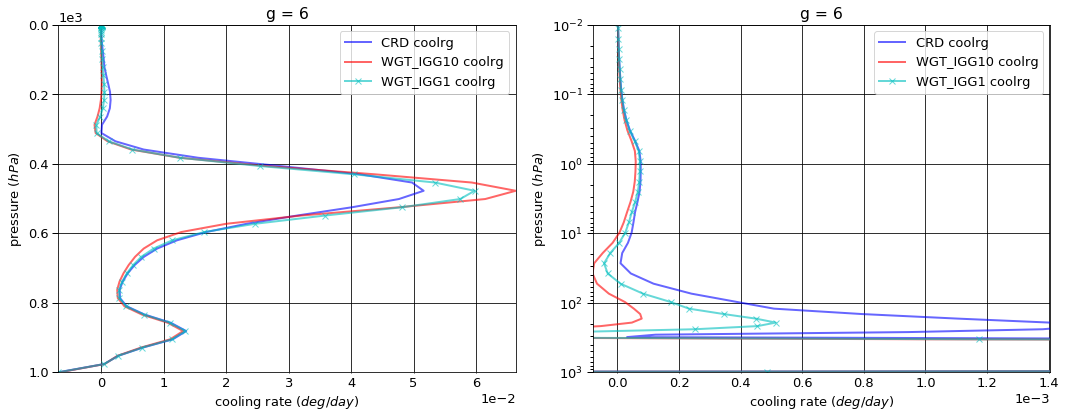

# Figure: cooling rate g-group 7

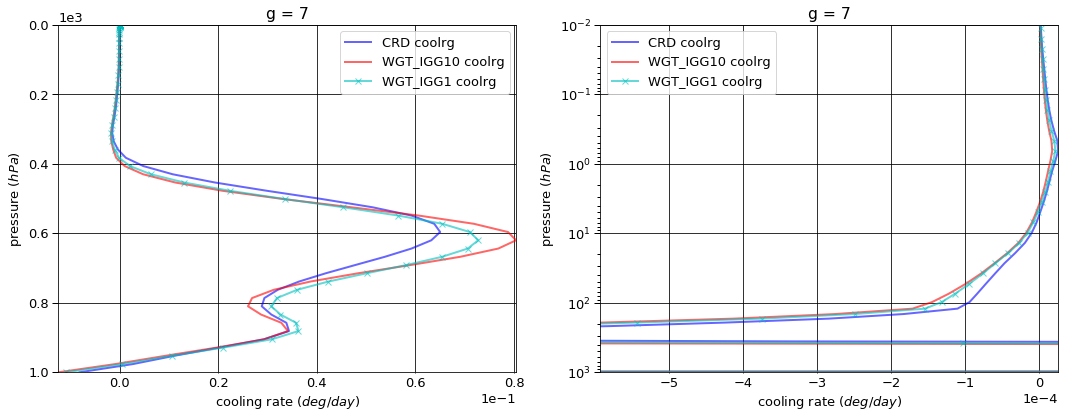

# Figure: cooling rate g-group 8

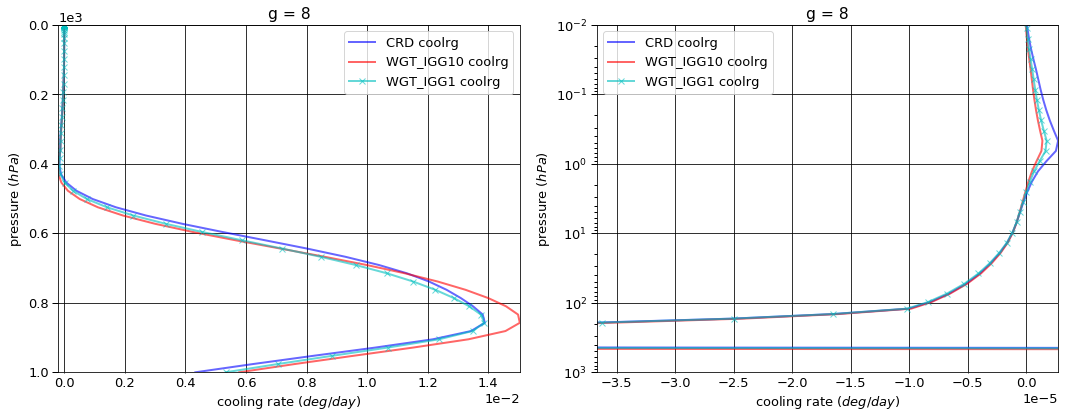

# Figure: cooling rate g-group total

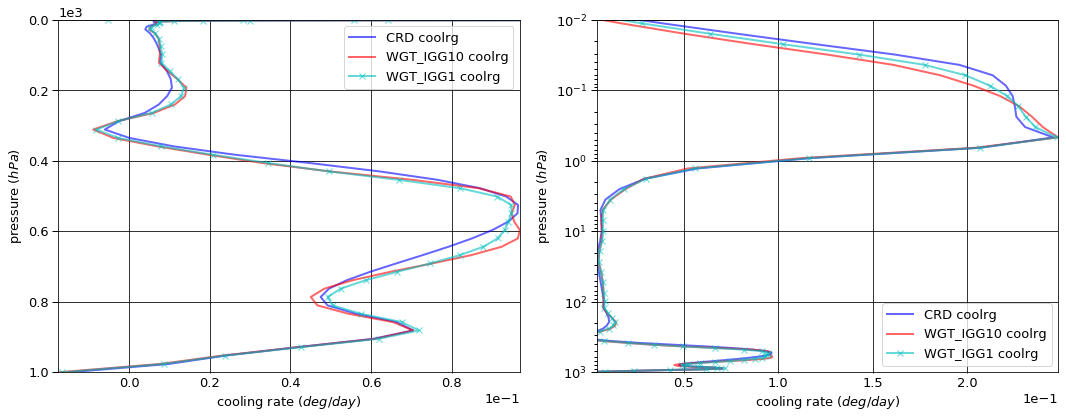

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009041  0.000000 -0.009041
  1013.0   76    -0.011429  0.011569  0.000140
2 0.0      1     -0.012901  0.000000 -0.012901
  1013.0   76    -0.026030  0.026349  0.000319
3 0.0      1     -0.015021  0.000000 -0.015021
  1013.0   76    -0.062332  0.063117  0.000785
4 0.0      1     -0.058847  0.000000 -0.058847
  1013.0   76    -0.300919  0.304666  0.003747
5 0.0      1     -0.453254  0.000000 -0.453254
  1013.0   76    -1.821329  1.844101  0.022772
6 0.0      1     -1.255462  0.000000 -1.255462
  1013.0   76    -3.310379  3.353032  0.042653
7 0.0      1     -2.420475  0.000000 -2.420475
  1013.0   76    -3.892652  3.965895  0.073243
8 0.0      1     -0.658807  0.000000 -0.658807
  1013.0   76    -0.756372  0.641023 -0.115349


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009649  0.000000 -0.009649
  1013.0   76    -0.011417  0.011557  0.000140
2 0.0      1     -0.012722  0.000000 -0.012722
  1013.0   76    -0.026023  0.026342  0.000318
3 0.0      1     -0.013170  0.000000 -0.013170
  1013.0   76    -0.062262  0.063024  0.000762
4 0.0      1     -0.054842  0.000000 -0.054842
  1013.0   76    -0.300676  0.304355  0.003679
5 0.0      1     -0.374652  0.000000 -0.374652
  1013.0   76    -1.820601  1.842875  0.022274
6 0.0      1     -1.284304  0.000000 -1.284304
  1013.0   76    -3.306698  3.348027  0.041329
7 0.0      1     -2.470471  0.000000 -2.470471
  1013.0   76    -3.903770  4.010854  0.107084
8 0.0      1     -0.670896  0.000000 -0.670896
  1013.0   76    -0.749993  0.638691 -0.111303


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009445  0.000000 -0.009445
  1013.0   76    -0.011417  0.011557  0.000140
2 0.0      1     -0.012755  0.000000 -0.012755
  1013.0   76    -0.026023  0.026342  0.000318
3 0.0      1     -0.013457  0.000000 -0.013457
  1013.0   76    -0.062262  0.063024  0.000762
4 0.0      1     -0.055199  0.000000 -0.055199
  1013.0   76    -0.300676  0.304355  0.003679
5 0.0      1     -0.379337  0.000000 -0.379337
  1013.0   76    -1.820601  1.842875  0.022274
6 0.0      1     -1.296294  0.000000 -1.296294
  1013.0   76    -3.306698  3.349057  0.042359
7 0.0      1     -2.486562  0.000000 -2.486562
  1013.0   76    -3.903770  4.010408  0.106638
8 0.0      1     -0.665774  0.000000 -0.665774
  1013.0   76    -0.749993  0.615419 -0.134574


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000608  0.000000 -6.081299e-04
  1013.0   76     0.000012 -0.000012 -6.837900e-07
2 0.0      1      0.000179  0.000000  1.790320e-04
  1013.0   76     0.000007 -0.000007 -3.812800e-07
3 0.0      1      0.001851  0.000000  1.850880e-03
  1013.0   76     0.000070 -0.000093 -2.306063e-05
4 0.0      1      0.004004  0.000000  4.004466e-03
  1013.0   76     0.000243 -0.000311 -6.820190e-05
5 0.0      1      0.078602  0.000000  7.860222e-02
  1013.0   76     0.000728 -0.001226 -4.981330e-04
6 0.0      1     -0.028842  0.000000 -2.884220e-02
  1013.0   76     0.003681 -0.005005 -1.323738e-03
7 0.0      1     -0.049996  0.000000 -4.999640e-02
  1013.0   76    -0.011118  0.044959  3.384065e-02
8 0.0      1     -0.012089  0.000000 -1.208921e-02
  1013.0   76     0.006378 -0.002332  4.046330e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000403  0.000000 -4.033673e-04
  1013.0   76     0.000012 -0.000012 -6.837900e-07
2 0.0      1      0.000145  0.000000  1.452170e-04
  1013.0   76     0.000007 -0.000007 -3.812800e-07
3 0.0      1      0.001565  0.000000  1.564511e-03
  1013.0   76     0.000070 -0.000093 -2.306063e-05
4 0.0      1      0.003648  0.000000  3.648362e-03
  1013.0   76     0.000243 -0.000311 -6.820190e-05
5 0.0      1      0.073916  0.000000  7.391649e-02
  1013.0   76     0.000728 -0.001226 -4.981330e-04
6 0.0      1     -0.040832  0.000000 -4.083200e-02
  1013.0   76     0.003681 -0.003975 -2.940480e-04
7 0.0      1     -0.066087  0.000000 -6.608720e-02
  1013.0   76    -0.011118  0.044514  3.339512e-02
8 0.0      1     -0.006967  0.000000 -6.966780e-03
  1013.0   76     0.006378 -0.025603 -1.922506e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.795090e-01
  1001.112500 75    -2.235678e-05
2 0.000312    1     -2.208472e-02
  1001.112500 75    -5.076873e-05
3 0.000312    1     -6.765348e-06
  1001.112500 75    -1.245946e-04
4 0.000312    1      6.273351e-06
  1001.112500 75    -5.940205e-04
5 0.000312    1     -2.492058e-05
  1001.112500 75    -3.592583e-03
6 0.000312    1     -1.422035e-07
  1001.112500 75    -6.868807e-03
7 0.000312    1     -1.026943e-06
  1001.112500 75    -8.114296e-03
8 0.000312    1     -3.790883e-07
  1001.112500 75     4.326693e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.541848e-01
  1001.112500 75    -2.224712e-05
2 0.000312    1     -6.936240e-03
  1001.112500 75    -5.070892e-05
3 0.000312    1      2.814885e-04
  1001.112500 75    -1.213245e-04
4 0.000312    1      3.699667e-05
  1001.112500 75    -5.859002e-04
5 0.000312    1      2.542090e-05
  1001.112500 75    -3.547640e-03
6 0.000312    1     -1.762797e-07
  1001.112500 75    -6.631854e-03
7 0.000312    1     -9.391155e-07
  1001.112500 75    -1.242131e-02
8 0.000312    1     -2.952714e-07
  1001.112500 75     5.775864e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.624873e-01
  1001.112500 75    -2.224712e-05
2 0.000312    1     -1.190431e-02
  1001.112500 75    -5.070892e-05
3 0.000312    1      1.833674e-04
  1001.112500 75    -1.213245e-04
4 0.000312    1      4.370360e-05
  1001.112500 75    -5.859002e-04
5 0.000312    1      3.113985e-05
  1001.112500 75    -3.547640e-03
6 0.000312    1     -1.229725e-07
  1001.112500 75    -6.844071e-03
7 0.000312    1     -9.312682e-07
  1001.112500 75    -1.086794e-02
8 0.000312    1     -3.134338e-07
  1001.112500 75     5.329141e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.532412e-02
  1001.112500 75     1.096640e-07
2 0.000312    1      1.514848e-02
  1001.112500 75     5.981000e-08
3 0.000312    1      2.882538e-04
  1001.112500 75     3.270070e-06
4 0.000312    1      3.072332e-05
  1001.112500 75     8.120300e-06
5 0.000312    1      5.034148e-05
  1001.112500 75     4.494260e-05
6 0.000312    1     -3.407614e-08
  1001.112500 75     2.369525e-04
7 0.000312    1      8.782759e-08
  1001.112500 75    -4.307016e-03
8 0.000312    1      8.381690e-08
  1001.112500 75     1.449171e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.702162e-02
  1001.112500 75     1.096640e-07
2 0.000312    1      1.018041e-02
  1001.112500 75     5.981000e-08
3 0.000312    1      1.901327e-04
  1001.112500 75     3.270070e-06
4 0.000312    1      3.743025e-05
  1001.112500 75     8.120300e-06
5 0.000312    1      5.606043e-05
  1001.112500 75     4.494260e-05
6 0.000312    1      1.923105e-08
  1001.112500 75     2.473570e-05
7 0.000312    1      9.567491e-08
  1001.112500 75    -2.753648e-03
8 0.000312    1      6.565457e-08
  1001.112500 75     1.002448e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.883807,0.000000,-4.883807
1013.0,76,-10.181441,10.209751,0.028310



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.890707,0.000000,-4.890707
1013.0,76,-10.181441,10.245724,0.064283



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.918822,0.000000,-4.918822
1013.0,76,-10.181441,10.223037,0.041596



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.899342e-03,0.000000,-0.006899
1013.0,76,-1.100000e-08,0.035973,0.035973



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.501477e-02,0.000000,-0.035015
1013.0,76,-1.100000e-08,0.013286,0.013286


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.201621
1001.112500,75,-0.015041



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.160779
1001.112500,75,-0.017605



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.174135
1001.112500,75,-0.016711



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.040842
1001.112500,75,-0.002564



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.027486
1001.112500,75,-0.001670


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.028350,0.029532
5,0.170713,0.178816
6,0.317971,0.324777
7,0.364756,0.383420
8,0.108631,0.073663


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,6.326694e-21
5,2.056007e-22
6,1.045323e-21
7,1.065660e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009793,1.0
4,6.326694e-21,0.323376,0.028350,0.029532,0.037929,0.039324,10.0
5,2.056007e-22,0.032497,0.170713,0.178816,0.208642,0.218140,10.0
6,1.045323e-21,5.084237,0.317971,0.324777,0.526613,0.542917,500.0
7,1.065660e-22,0.101946,0.364756,0.383420,0.891369,0.926337,500.0
8,1.086393e-23,0.101946,0.108631,0.073663,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
